# Extracting Excitation Coefficients

The goal of this code is to import SXS data, limiting to spin $\Chi = 0.69 \pm 0.05$ or close to it, then fit the $l=2, m=2$ waveform to a damped sinusoid model. After fitting, the coefficients for up to overtone $N=7$ is extracting and stored.

In [1]:
# For downloading data
import sxs

# For interacting with the data
import h5py
import numpy as np
from matplotlib import pyplot as plt
import json
import pandas as pd

#Other libraries
import math
from lmfit import Model, minimize, Parameters
import scipy
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from scipy import integrate
from scipy import signal
from sklearn import preprocessing
import qnm

Obtain data from the SXS Catalog and then store BBH Mergers with spins close to $\chi = 0.69 \pm 0.5$. Then store the name of the simulation, the waveform, the spin, and the mass into their respective array for later use.

In [2]:
#Initializing arrays that will be used for the fitting function
waveforms = []
names = []
spins = []
masses = []

#Loop through the entire SXS BBH catalog
for i in range(2300):
    #Catch exception block is here because I didnt want to check how many BBH simulations there are, I know its over 2265, so I put 2300.
    try:
        #Change the format of i from say, 1 to 0001 as the SXS BBH catalog has its files names in that format
        i = '{0:04}'.format(i)

        #Load the metadata to get the spin and mass information, spin is most important right now
        mtdt = sxs.load(f"SXS:BBH:{i}/Lev/metadata.json", download = False)
        spin = mtdt.remnant_dimensionless_spin[2]
        mass = mtdt.remnant_mass
        
        #Most of the BBHs with random spin orientations will converge to Chi = 0.69, which is what we're looking for to compare the overtone numbers.
        if 0.65 <= spin <= 0.75:
            #If the spin matches, then load the large waveform rhOVerM file, it will download if not already stored locally and each is about 80-100 mb
            #Store all the information of masses, spins, etc to the arrays
            names.append(i)
            spins.append(spin)
            masses.append(mass)
            w = sxs.load(f"SXS:BBH:{i}/Lev/rhOverM", extrapolation_order=2, download = False)
            waveforms.append([i,w])
    except:
        pass

Found the following files to load from the SXS catalog:
    SXS:BBH:0001v6/Lev5/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0001v6/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0002v7/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0002v7/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0003v5/Lev5/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0003v5/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0004v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0005v5/Lev5/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0006v5/Lev5/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0007v

We have to obtain the quasinormal modes. So first using the qnm library, we extract all the qnms for the desired spin by looping through all the NR Simulations and putting in the spin to obtain the QNM for the fundamental mode and the first 7 overtones

In [3]:
# Initialize an empty list to store the final result
all_omega = []

# Loop over all spins
for j in range(len(spins)):
    # Initialize an empty list to store the freq values for this spin
    omega = []
    
    # Loop over all overtones
    for i in range(8):
        # Calculate the grav_220 mode for this overtone
        grav_220 = qnm.modes_cache(s=-2,l=2,m=2,n=i)
        
        # Calculate the freq, A, and B values for this spin and overtone
        freq, A, B = grav_220(a=spins[j])
        
        # Append the freq value to the omega list
        omega.append(freq)
    
    # Append the omega list for this spin to the all_omega list
    all_omega.append(omega)

In [21]:
# Convert the all_omega list to a pandas DataFrame
qnmFreq_df = pd.DataFrame(all_omega, columns=[f'N={i}' for i in range(8)])
qnmFreq_df.insert(0, "Name", names)
qnmFreq_df.insert(1, "Spin", spins)
qnmFreq_df.insert(2, "Remnant Mass", masses)

In [22]:
qnmFreq_df

,Name,Spin,Remnant Mass,N=0,N=1,N=2,N=3,N=4,N=5,N=6,N=7
0,0001,0.686462,0.951609,0.526704-0.081288j,0.514860-0.245813j,0.492964-0.415136j,0.463866-0.588731j,0.432914-0.760352j,0.415548-0.927633j,0.414827-1.107500j,0.415936-1.301166j
1,0002,0.686448,0.951610,0.526698-0.081289j,0.514853-0.245815j,0.492957-0.415139j,0.463859-0.588736j,0.432906-0.760358j,0.415540-0.927643j,0.414818-1.107512j,0.415926-1.301179j
2,0003,0.691447,0.951083,0.528846-0.081110j,0.517150-0.245245j,0.495488-0.414097j,0.466582-0.587123j,0.435638-0.757964j,0.418439-0.924115j,0.418123-1.103112j,0.419441-1.296070j
3,0007,0.664091,0.955270,0.517478-0.082034j,0.504985-0.248199j,0.482071-0.419546j,0.452136-0.595644j,0.421057-0.770712j,0.402856-0.942781j,0.400411-1.126329j,0.400630-1.323009j
4,0008,0.664091,0.955267,0.517478-0.082034j,0.504985-0.248199j,0.482071-0.419546j,0.452136-0.595644j,0.421057-0.770713j,0.402855-0.942781j,0.400410-1.126329j,0.400630-1.323009j
...,...,...,...,...,...,...,...,...,...,...,...
590,2153,0.661903,0.966646,0.516608-0.082102j,0.504053-0.248420j,0.481042-0.419956j,0.451027-0.596295j,0.419928-0.771696j,0.401638-0.944209j,0.399032-1.128099j,0.399169-1.325061j
591,2154,0.670840,0.965718,0.520197-0.081818j,0.507897-0.247506j,0.485286-0.418257j,0.455599-0.593609j,0.424574-0.767646j,0.406637-0.938317j,0.404696-1.120791j,0.405178-1.316588j
592,2155,0.679580,0.964696,0.523800-0.081527j,0.511754-0.246574j,0.489540-0.416535j,0.460180-0.590909j,0.429205-0.763599j,0.411596-0.932401j,0.410328-1.113438j,0.411156-1.308058j
593,2156,0.695775,0.965339,0.530733-0.080951j,0.519166-0.244741j,0.497710-0.413176j,0.468973-0.585705j,0.438028-0.755868j,0.420966-0.921016j,0.421011-1.099241j,0.422512-1.291574j


In [33]:
only_wav = [row[1] for row in waveforms]

# The Fitting

A non-linear least-squares minimization is done on the waveform and fitted to $$h_{lm}^N(t) = d + \sum_{n=0}^N C_{lmn}e^{-i\omega_{lmn}(t-t_0)}$$ where $h_{lm}^N(t)$ will be the complex strain and $t$ is the time from the waveform in the NR simulation. The coefficients $C_{lmn}$ is what is going to be extracted from the fitting.

The function takes in the start time $T$ which tells how far after the peak strain time should the fitting start $t_0$, then it takes the waveform for the y values in the fitting, then the spin for calculating the qnm frequencies which after dividing after the next input, the mass, will provide the $\omega_{lmn}$. Once the fitting is done until $t_0 + 90M$ the lmfit parameters are returned.

In [59]:
def minWaveform(T, w, spin, mass):
    t_0 = w.max_norm_time() + T
    # Calculate omega array using a list comprehension
    omega = np.asarray([qnm.modes_cache(s=-2, l=2, m=2, n=i)(a=spin)[0] for i in range(8)])
    
    # Calculate dimensionless qnm frequency
    freq = omega / mass
    
    # Initialize Parameters object
    params = Parameters()
    
    # Add C and phi parameters for each overtone
    for i in range(len(freq)):
        params.add(f'C_{i}', value=0., vary=True)
        params.add(f'phi_{i}', value=0., vary=True)
    
    # Add const parameter
    params.add('const', value=0., vary=True)
    
    # Define h function
    def h(params, t):
        h_s = [params[f'C_{i}'].value * np.exp(-1j * (freq[i] * (t - t_0) + params[f'phi_{i}'].value)) for i in range(len(freq))]
        h_s.append(params['const'].value)
        return sum(h_s)

    # Define funcBoth function
    def funcBoth(params, t, data):
        N = len(t)
        t_real = t[N//2:]
        t_imag = t[:N//2]
        h_real = np.real(h(params, t_real))
        h_imag = np.imag(h(params, t_imag))
        return np.vstack([h_real, h_imag]) - np.vstack([data[:N//2], data[N//2:]])
    
    # Get ringdown waveform data
    i1 = w.index_closest_to(t_0)
    i2 = w.index_closest_to(w.max_norm_time() + 90.0)
    w_ringdown = w[i1:i2]
    w_2_2_ringdown = w_ringdown[:, w_ringdown.index(2, 2)]
    
    # Prepare data for minimization
    tdata = np.hstack([w_2_2_ringdown.t, w_2_2_ringdown.t])
    wdata = np.hstack([w_2_2_ringdown.data.real, w_2_2_ringdown.data.imag])
    
    # Perform minimization
    out = minimize(funcBoth, params, args=(tdata, wdata))
    
    return out

In [46]:
times_after = np.linspace(0,25,6)

In [70]:
exciteCoefs = []

for i in range(len(names[:5])):
    print(i)
    exciteCoefs.append(minWaveform(times_after[0], waveforms[i][1], spins[i], masses[i]))

0
1
2
3
4


In [71]:
timeAmplitude = exciteCoefs

In [72]:
param_values = []
for minimizer_result in timeAmplitude:
    values = [param.value for param in minimizer_result.params.values()]
    param_values.append(values)

In [84]:
param_values[0]

[0.9507659091822734,
 -0.6690622375816772,
 -3.9228109447655495,
 -1.72120372037849,
 -11.387638679110603,
 0.9466352794638069,
 26.874528890793865,
 0.895424759729753,
 -45.01705744519322,
 1.065717858977951,
 -45.26917443609964,
 -1.855112213468027,
 -24.094928532850002,
 1.4828232179176455,
 -5.2951103617624815,
 4.73955974352272,
 0.0007970050248157826]

In [92]:
normalized_amplitudes = []
pure_amplitudes = []

for result_values in param_values:
    norm_amps = []
    pure_amps = []
    result_values = np.abs(result_values)
    for i in range(8):
        pure_amp = abs(result_values[2 * i])
        pure_amps.append(pure_amp)
        norm_amp = pure_amp / max(result_values)
        norm_amps.append(norm_amp)
    normalized_amplitudes.append(norm_amps)
    pure_amplitudes.append(pure_amps)

In [95]:
phases = []

for result_values in param_values:
    phase_vals = [result_values[2 * i + 1] for i in range(8)]
    phases.append(phase_vals)

In [104]:
overtones = np.arange(0,8)

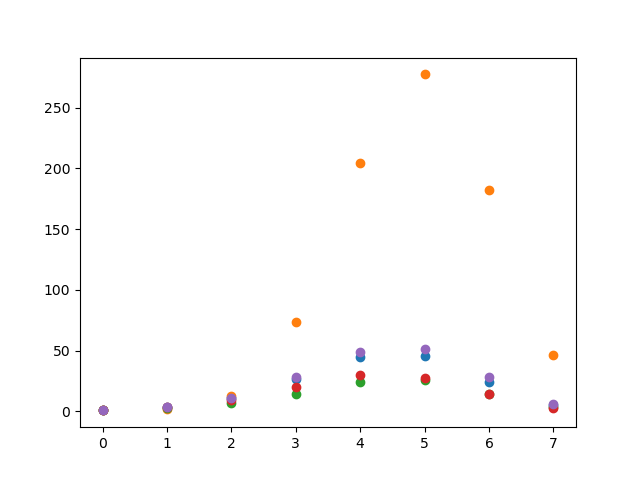

In [111]:
%matplotlib widget

for amplitudes in pure_amplitudes:
    plt.scatter(overtones, amplitudes)
plt.show()

In [48]:
values = [list(mw.params.values())[i].value for i in range(len(list(mw.params.values())))]
colnames = list(mw.params.keys())
# Create DataFrame with column names 0 through 7
df = pd.DataFrame([values], columns=colnames)

# Print DataFrame
df

,C_0,phi_0,C_1,phi_1,C_2,phi_2,C_3,phi_3,C_4,phi_4,C_5,phi_5,C_6,phi_6,C_7,phi_7,const
0,0.950766,-0.669062,-3.922811,-1.721204,-11.387639,0.946635,26.874529,0.895425,-45.017057,1.065718,-45.269174,-1.855112,-24.094929,1.482823,-5.29511,4.73956,0.000797


In [75]:
df.index = [names[0]]

In [ ]:
# Calculate timeAmplitude list using nested list comprehensions
timeAmplitude = [[parent_cof(T, waveforms[i], spins[i], masses[i]) for i in range(len(names))] for T in times_after]

# Calculate timeAmpi list using nested list comprehensions
timeAmpi = [[[list(timeAmplitude[t][k].params.values())[i].value for i in range(len(list(timeAmplitude[t][k].params.values())))] for k in range(len(names))] for t in range(len(timeAmplitude))]

# Calculate timenameCof list using a nested list comprehension
timenameCof = [[[names[i], timeAmpi[t][i]] for i in range(len(timeAmpi[t]))] for t in range(len(timeAmpi))]